In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
sns.set_style("whitegrid")
mpl.rcParams['figure.dpi'] = 100

params_grid = {"color": 'lightgrey', "linestyle": 'dotted', "linewidth": 0.7 }

# American Put Option - CRR model

The CRR model is a binomial model that allows us to understand the principle of the algorithm of Longstaff-Schwartz that works backwarding. Indeed, for an american option we can exerce it any time before maturity $T$. 

What is behind the CRR model and more genrally the LS algorthm ? 

In the binomial model, we discretize both time and Gain/Cost. The principle is to find the expected winning/cost at each time $ t_n = n \frac{T}{N}$  where $n = 0, ..., N$ if we use the option at each of those times. Hence by thinking backwarding, at each step $i$, we must choose the maximum between the expected gain if we continue the game or if we stop at step n.

Mathematically, it corresponds to the following definition and properties.

We denote $X_n = X_{t_{n}}$ a markov chain (ex : an asset) with $P_n$ for transition matrix. We denote $Z_n = \phi_n(X_n)$ the actual payoff of the option. For instance, if we have an American Put, we will have $\phi(x) = (K-s)_{+}$

Then the algorithm to find the price of this option is : 
$$V_N(x) = \phi_N(x)$$
$$V_n(x) = max(\phi_n(x),P_{n+1} V_{n+1}(x)$$

### Parameter Option

In [3]:
# Parameter of the model

N = 10      # Nomber of periods to build the binomial tree
M = 10000
T = 1
S0 = 100
K = 100
sigma = 0.1
r = 0.04
u = np.exp(sigma * np.sqrt(T/N))
d = 1/u
p = (1+(r-0.5*sigma**2)*np.sqrt(T/N)/(2*sigma))
if N < (r-0.5 * sigma**2)**2 * T/(sigma**2):
    print("Error")

if (N <= 10):
    size_N = 60  
    lw_N = 2     

if (N > 10):
    size_N = 6
    lw_N = 1.5

In [4]:
# states represent the possible values in n : 
# states of a Markov Chain : X_n

states = np.array([np.arange(i+1) for i in range(N+1)], dtype = object)

payoffs = [np.exp(-r*n*T/N)*np.maximum(K-S0*(u**xn)*(d**(n-xn)), 0) for n,xn in enumerate(states)]
payoffs[3]

array([8.9427723 , 3.07567019, 0.        , 0.        ])

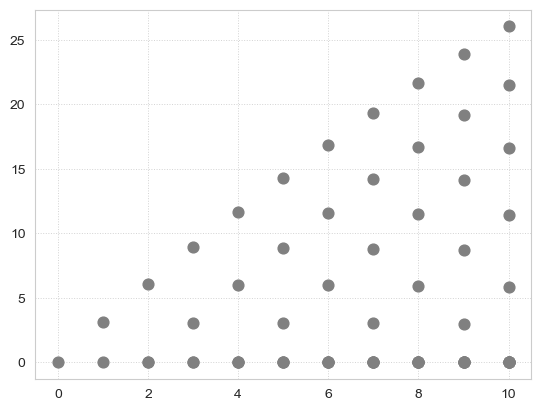

In [5]:

fig, ax = plt.subplots()
ax.grid(**params_grid)
for n in range(N+1):
    for z in payoffs[n]:
        ax.scatter(n, z, color='grey', marker='o', s=size_N)


In [6]:
# transition matrix of the markov chain
P = [np.zeros((len(states[n]), len(states[n+1]))) for n in range(N)]
for n in range(N):
    for i, x in enumerate(states[n]):
        for j, y in enumerate(states[n+1]):
            #proba risque neutre
            q = (np.exp(r*T/N)-d)/(u-d)
            if (y==x):
                P[n][i,j] = 1-q
            elif y==x+1:
                P[n][i,j] = q

P[3]


array([[0.44454338, 0.55545662, 0.        , 0.        , 0.        ],
       [0.        , 0.44454338, 0.55545662, 0.        , 0.        ],
       [0.        , 0.        , 0.44454338, 0.55545662, 0.        ],
       [0.        , 0.        , 0.        , 0.44454338, 0.55545662]])

# Construction of the values function $V_n$

In [7]:
V = [np.copy(payoffs[n]) for n in range(N+1)]
for n in reversed(range(N)):
    # payoffs[n] corresponds to Z_n
    # P[n] @ V[n+1] corresponds to the conditional esperance  E[S_{n+1} | F_n] où S_n = V_n(X_n)
    V[n] = np.maximum(payoffs[n], P[n] @ V[n+1]) # backwarding recurrence on the values function

In [8]:
V[0]

array([2.61692878])

In [10]:
print(f"The value of an American Put is: {V[0][0]:.6}")


The value of an American Put is: 2.61693


# Bonus : Moyennisation sur M scénarios

In [11]:
stop = [(payoffs[n] == V[n]).astype('int') for n in range(N+1)]


M = int(1e4)
gains_opt = np.zeros(M)
path = np.zeros(N+1, dtype=int)
for j in range(M):
    for n in range(1, N+1): 
        path[n] = np.random.choice(np.arange(P[n-1].shape[1]), 1, p=P[n-1][path[n-1]])[0]
        if (stop[n][path[n]] == 1): break # on sort et la valeur n est figée 
    gains_opt[j] = payoffs[n][path[n]]  

# V_0 = E[Z_\tau^*] 
m = np.mean(gains_opt)
ic_size = 1.96 * np.sqrt(np.var(gains_opt, ddof=1) / M) 
print(f"The value of the estimator with {M} draw is : {m:.4}, and the estimated variance is {np.var(gains_opt):.4}.")
print(f"The true value belongs to the interval [{m-ic_size:.4}, {m+ic_size:.4}] with proba  0.95 (M = {M}).")
print(f"The true value is : {V[0][0]:.6}")



The value of the estimator with 10000 draw is : 2.614, and the estimated variance is 10.43.
The true value belongs to the interval [2.55, 2.677] with proba  0.95 (M = 10000).
The true value is : 2.61693
